In [1]:
import numpy as np
import pylab as plt
import networkx as nx
import scipy.integrate as integ
from multiprocessing import Pool

from utils import *

%matplotlib notebook

<IPython.core.display.Javascript object>


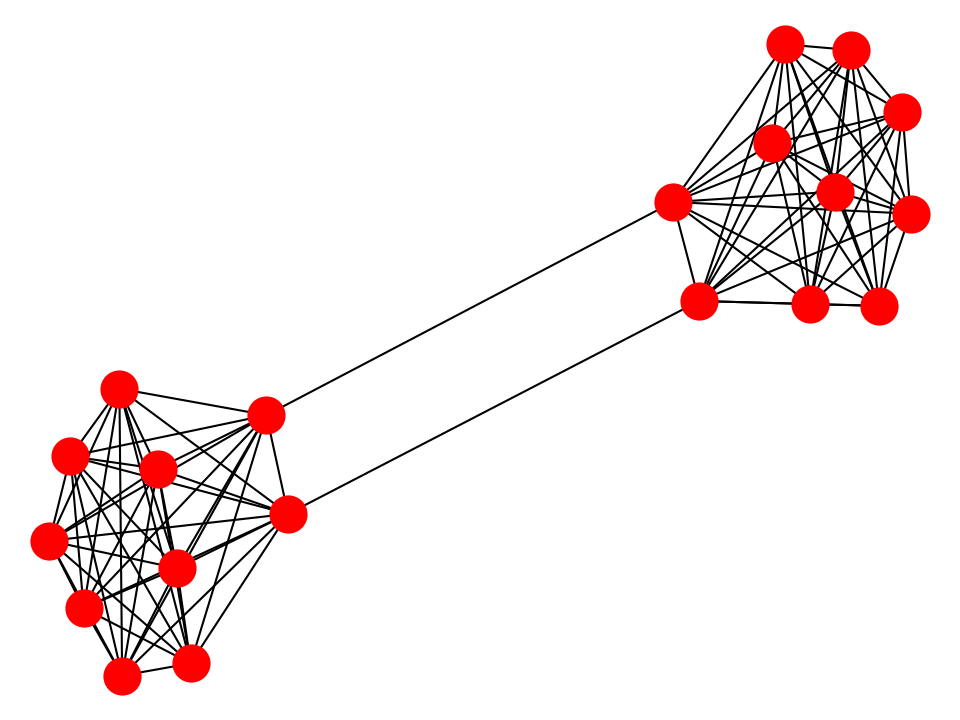

In [2]:
%matplotlib notebook
G = nx.newman_watts_strogatz_graph(20, 2, 0.5)
G=Modules_full(2,10,2)

pos = nx.spring_layout(G)
plt.figure()
nx.draw(G, pos = pos)

In [3]:
B, Bplus, v, w = compute_eig_projection(G)

<IPython.core.display.Javascript object>


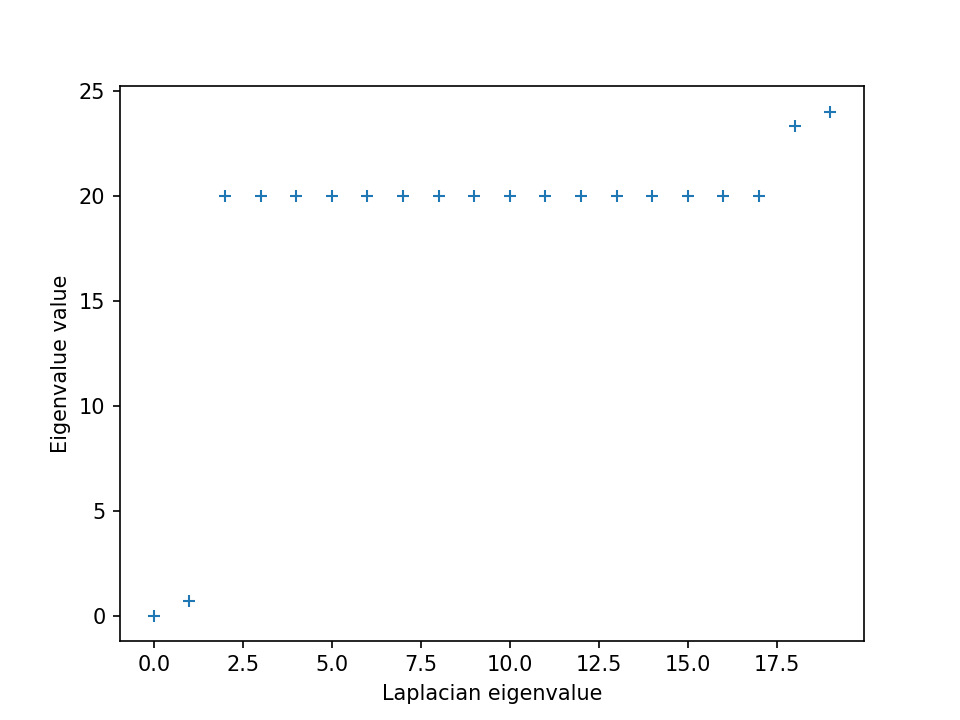

Text(0,0.5,'Eigenvalue value')

In [4]:


plt.figure()
plt.plot(w,'+')
plt.xlabel('Laplacian eigenvalue')
plt.ylabel('Eigenvalue value')

<IPython.core.display.Javascript object>


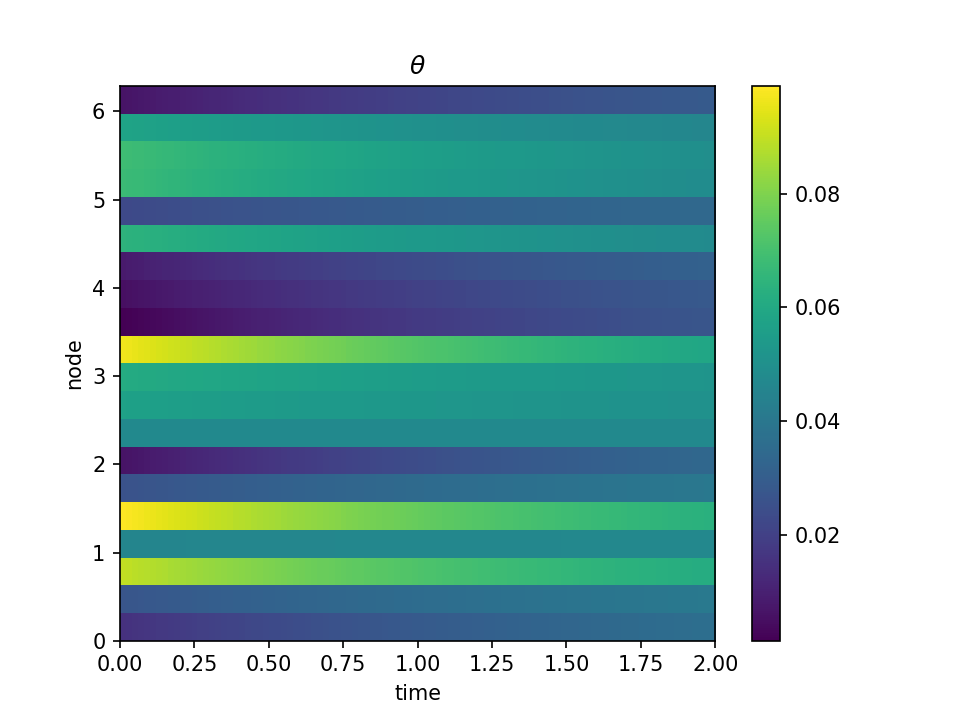

<IPython.core.display.Javascript object>


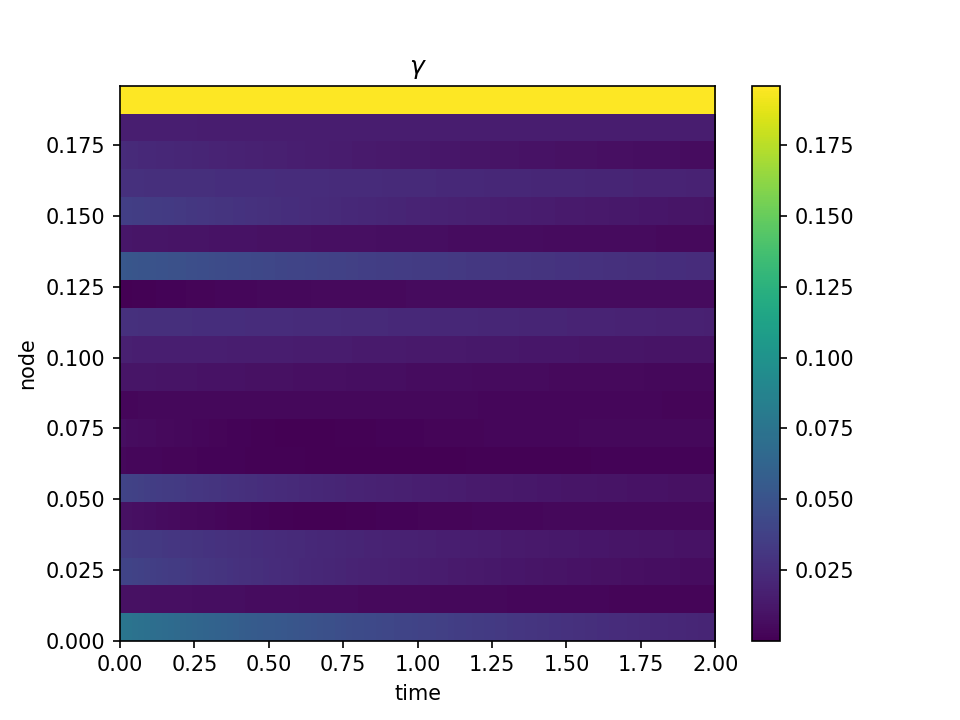

In [5]:
#initial conditions

theta_0 = .1*np.random.rand(len(G))
omega_0 = np.zeros(len(G))

gamma_0 = theta_0.dot(v)

a = 1 #coupling constant
alpha = 0.0 #frustration
t_max = 2 #integration time
n_t = 100 #number of timepoints 

result_theta = integrate_kuramoto_full_theta(B, Bplus, theta_0, t_max, n_t, alpha, a, omega_0)
result_gamma = integrate_kuramoto_full_gamma(B, Bplus, v, gamma_0, t_max, n_t, alpha, a, omega_0)

times = result_theta.t
theta = np.mod(result_theta.y,2*math.pi) #result_theta.y
gamma = np.abs(result_gamma.y)

plt.figure()
plt.imshow(theta, aspect='auto', extent = (0, t_max, 0, np.pi*2 ))
plt.xlabel('time')
plt.ylabel('node')
plt.title(r'$\theta$')
plt.colorbar()

plt.figure()
plt.imshow(gamma, aspect='auto', extent = (0, t_max, np.min(gamma),np.max(gamma) ))
plt.xlabel('time')
plt.ylabel('node')
plt.title(r'$\gamma$')

plt.colorbar()

<IPython.core.display.Javascript object>


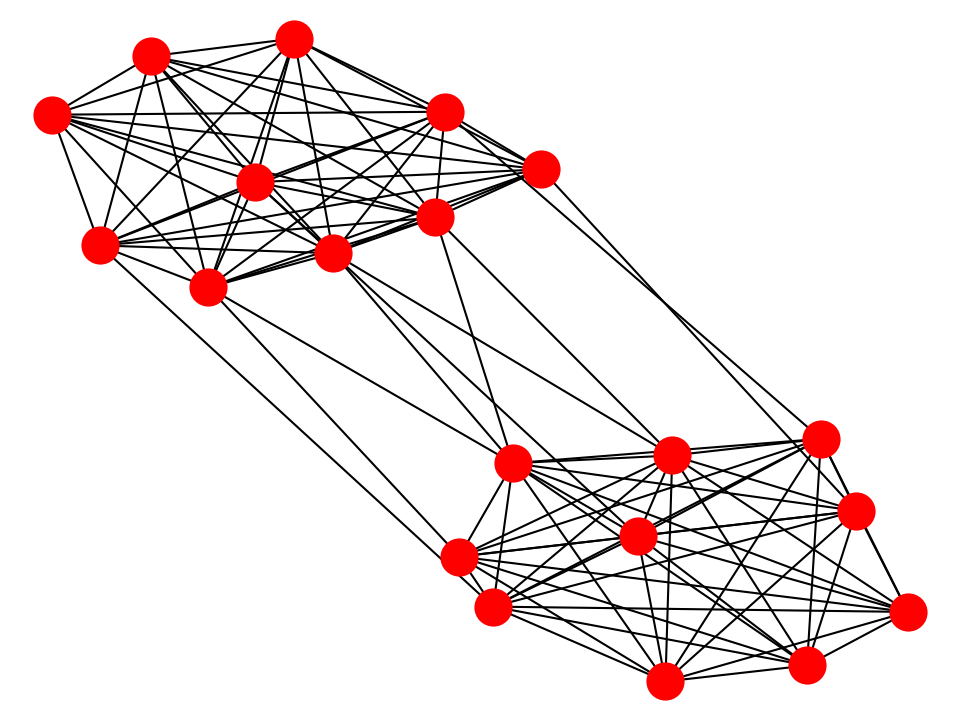

<IPython.core.display.Javascript object>


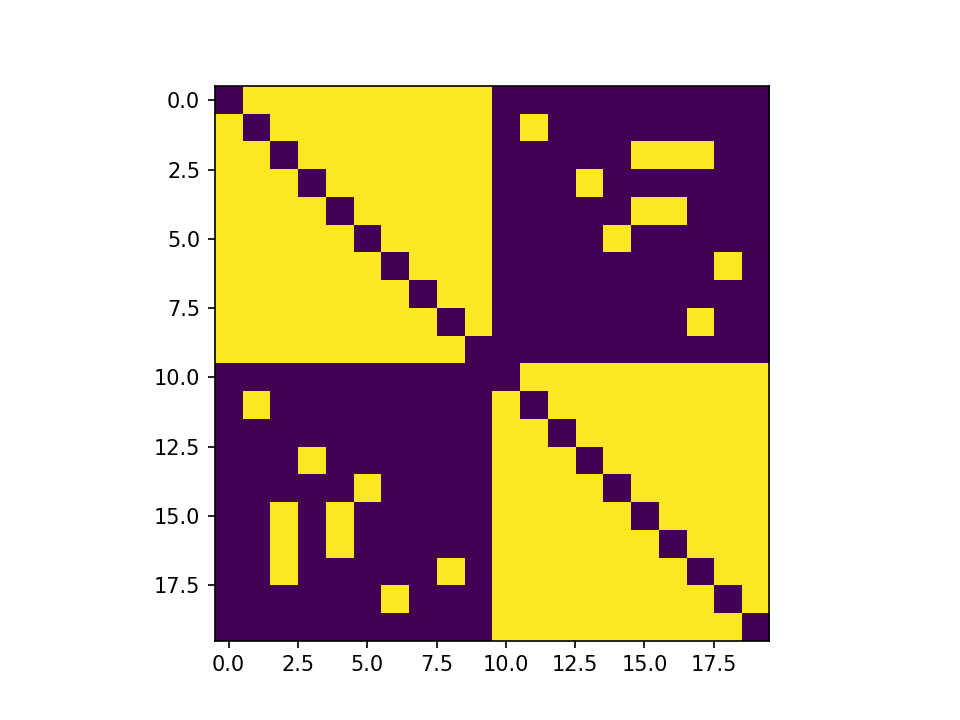

In [6]:
# example with modular graph and alpha

Nc = 2
Nn = 10

G = Modules_full(Nc,Nn,Nn)
B, Bplus, v, w=compute_eig_projection(G)

pos = nx.spring_layout(G)
plt.figure()
nx.draw(G, pos = pos)

A=np.asarray(nx.to_numpy_matrix(G))
degree=A.sum(0)

plt.figure()
plt.imshow(A)

<IPython.core.display.Javascript object>


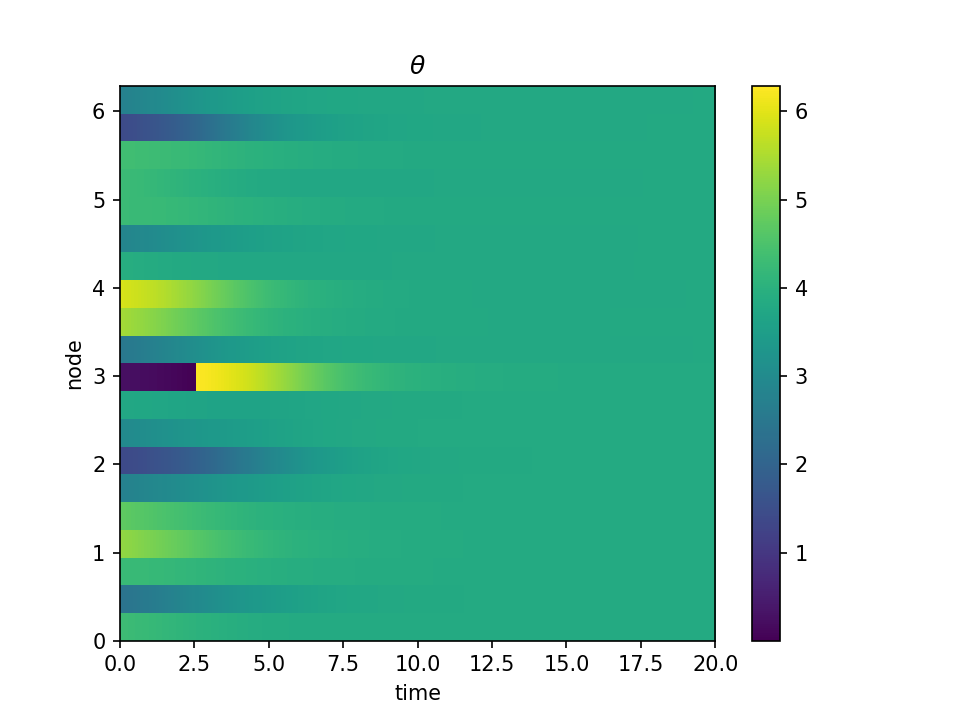

In [7]:
#initial conditions
theta_0 = np.random.uniform(0, 2*np.pi, len(G))
omega_0 = np.zeros(len(G)) 

gamma_0 = theta_0.dot(v)

a = 1 #coupling constant
alpha = 0.0 #frustration
t_max = 20 #integration time
n_t = 1000 #number of timepoints 

sol_alt = integrate_kuramoto_full_theta(B, Bplus, theta_0, t_max, n_t, alpha, a, omega_0)
sol_alt.y = np.mod(sol_alt.y, 2*np.pi)



plt.figure()
plt.imshow(sol_alt.y, aspect='auto', extent = (0, t_max, 0, np.pi*2 ))
plt.xlabel('time')
plt.ylabel('node')
plt.title(r'$\theta$')
plt.colorbar()

<IPython.core.display.Javascript object>


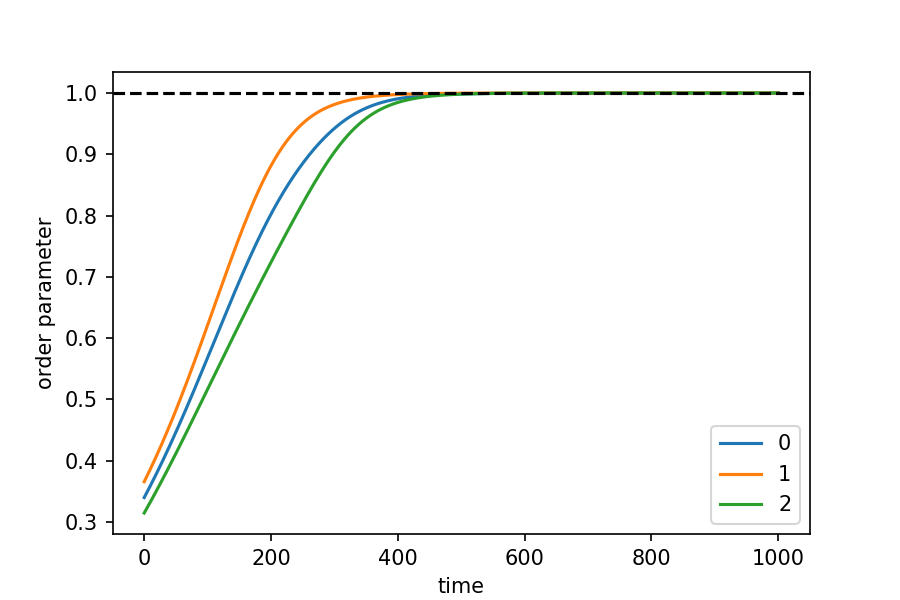

Text(0,0.5,'order parameter')

In [15]:
op = order_parameter(sol_alt.y, Nc, Nn)
lt, chit = Shanahan_indices(op)

plt.figure(figsize=(6,4))
for i in range(np.shape(op)[0]):
    plt.plot(np.linspace(0, n_t, n_t), op[i,:], label=i)
    
plt.legend(loc='best')
plt.axhline(1, c='k', ls='--')
plt.xlabel('time')
plt.ylabel('order parameter')

<IPython.core.display.Javascript object>


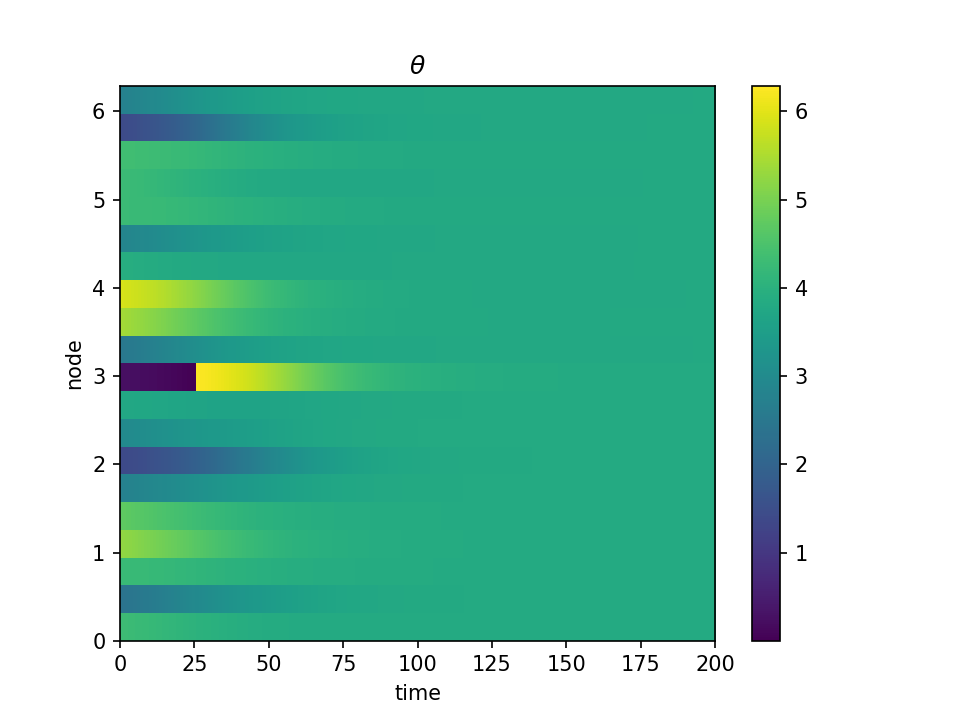

<IPython.core.display.Javascript object>


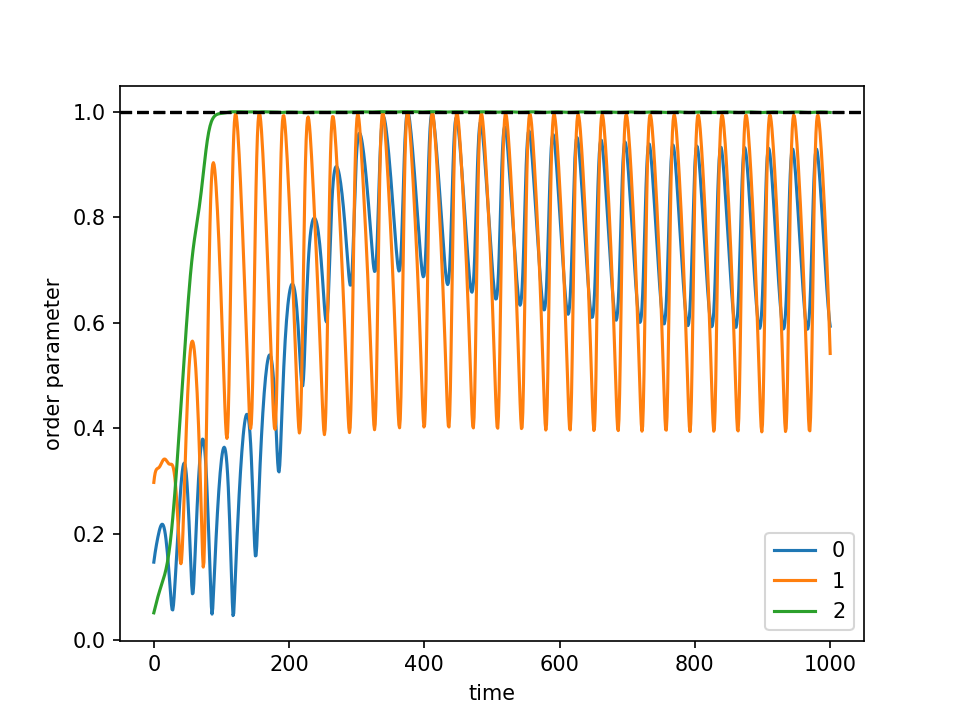

Text(0,0.5,'order parameter')

In [18]:
# example with two "driving" nodes
Nc = 2
Nn = 10

G = Modules_full(Nc, Nn, Nn)
B, Bp, v, w = compute_eig_projection(G)

theta_0 = np.random.uniform(0, 2*np.pi, Nc*Nn)
omega_0 = np.ones(Nc*Nn)
omega_0[0:3]=0

t_max = 200
n_t = 1000

a = 1
alpha = 0

sol_full = integrate_kuramoto_full_theta(B, Bplus, theta_0, t_max, n_t, alpha, a, omega_0)
sol_full.y = np.mod(sol_full.y, 2*np.pi)

op = order_parameter(sol_full.y, Nc, Nn)

plt.figure()
plt.imshow(sol_alt.y, aspect='auto', extent = (0, t_max, 0, np.pi*2 ))
plt.xlabel('time')
plt.ylabel('node')
plt.title(r'$\theta$')
plt.colorbar()

plt.figure()
for i in range(np.shape(op)[0]):
    plt.plot(np.linspace(0, n_t, n_t), op[i,:], label=i)
    plt.axhline(1, c='k', ls='--')
    
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('order parameter')

In [41]:
# scanning the alpha
Nc = 2
Nn = 10
G = Modules_full(Nc, Nn, 5)
B, Bplus, v, w = compute_eig_projection(G)

a = 1
t_max = 500
n_t = 5000
omega_0 = np.zeros(Nc*Nn)


nlag = 50 #number of alpha points
lag = np.linspace(0, np.pi/2.+0.5, nlag)
nrep = 10 #number of repetition for variance


    
def run_alpha(alpha):
    lt = np.zeros(nrep)
    chit = np.zeros(nrep)

    for n in range(nrep):
        theta_0 = np.random.uniform(0, 2*np.pi, Nc*Nn)

        sol_full = integrate_kuramoto_full_theta(B, Bplus, theta_0, t_max, n_t, alpha, a, omega_0)
        sol_full.y = np.mod(sol_full.y, 2*np.pi)

        op = order_parameter(sol_full.y, Nc, Nn)
        lt[n], chit[n] = Shanahan_indices(op)
        
    return lt, chit

        

n_processes = 4
with Pool(processes= n_processes) as p_alpha:  #initialise the parallel computation
    out = p_alpha.map(run_alpha, lag) #run the MI

l = np.zeros([nlag,nrep])
chi = np.zeros([nlag,nrep])


for i in range(nlag):
    l[i] = out[i][0]
    chi[i] = out[i][1]

<IPython.core.display.Javascript object>


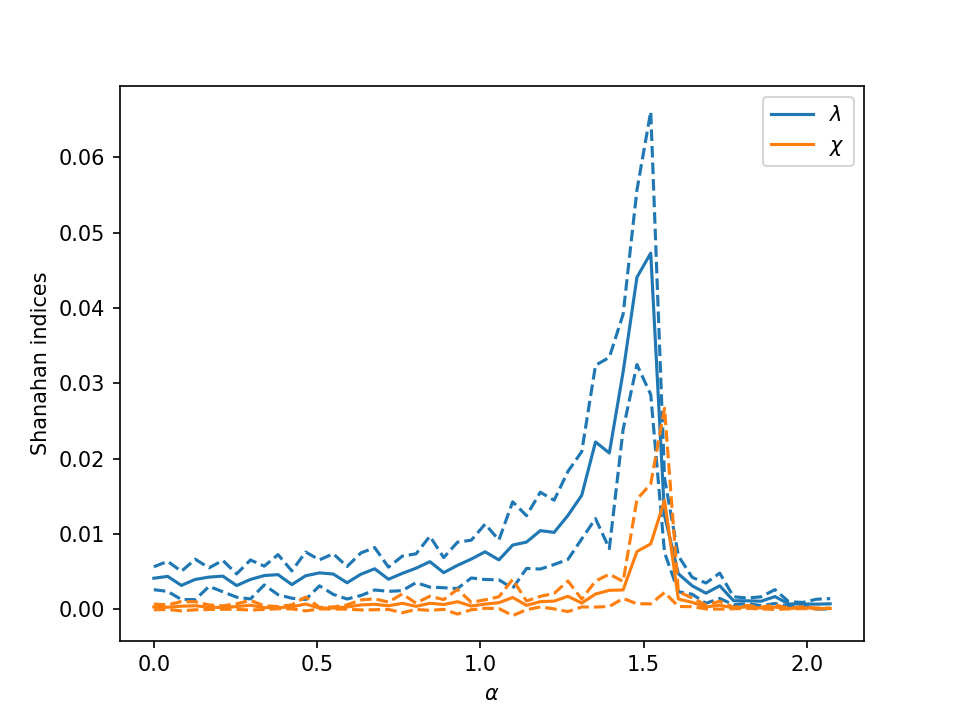

In [42]:
plt.figure()
plt.plot(lag, l.mean(1),'C0-', label= r'$\lambda$')
plt.plot(lag, l.mean(1)-l.std(1), 'C0--')
plt.plot(lag, l.mean(1)+l.std(1), 'C0--')

plt.plot(lag, chi.mean(1), 'C1-', label = r'$\chi$')
plt.plot(lag, chi.mean(1)+chi.std(1), 'C1--')
plt.plot(lag, chi.mean(1)-chi.std(1), 'C1--')

plt.xlabel(r'$\alpha$')
plt.ylabel('Shanahan indices')
plt.legend(loc='best')